In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

## Preparation & Analysis

In [2]:
df = pd.read_csv(r'C:/Users/kevin/datasets/taxi.csv')

In [3]:
df.info()
print()
print("The Datetime is in Chronological Order:", df.index.is_monotonic)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB

The Datetime is in Chronological Order: True


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
print(df.head(25))
print(df.tail(25))

              datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32
5  2018-03-01 00:50:00          21
6  2018-03-01 01:00:00           7
7  2018-03-01 01:10:00           5
8  2018-03-01 01:20:00          17
9  2018-03-01 01:30:00          12
10 2018-03-01 01:40:00          19
11 2018-03-01 01:50:00          25
12 2018-03-01 02:00:00          22
13 2018-03-01 02:10:00          12
14 2018-03-01 02:20:00          19
15 2018-03-01 02:30:00           8
16 2018-03-01 02:40:00           6
17 2018-03-01 02:50:00           4
18 2018-03-01 03:00:00           8
19 2018-03-01 03:10:00          17
20 2018-03-01 03:20:00           7
21 2018-03-01 03:30:00           4
22 2018-03-01 03:40:00          10
23 2018-03-01 03:50:00          20
24 2018-03-01 04:00:00          13
                 datetime  num_orders
26471 2018-08-31 19:50:00          15
26472 2018-08-

Data is dated between March 1st 2018 - August 31st 2018

In [6]:
df = df.set_index('datetime')

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]


Text(0.5, 1.0, 'Taxi Orders from March 2018 to August 2018')

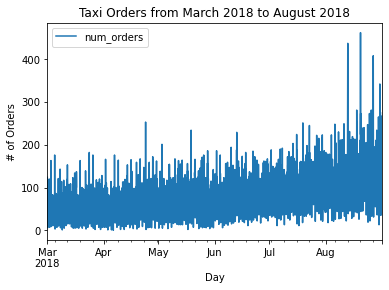

In [7]:
df = df.resample('1H').sum()
print(df)
df.plot()
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.title('Taxi Orders from March 2018 to August 2018')

Based on the graph, orders tend to gradually increase over the months, and inflate in August. 

In [8]:
# rolling statistics

def test_station(timeseries):
    rollingmean = timeseries.rolling(6).mean()
    rollingstd = timeseries.rolling(6).std() # 6 represents months in the dataset. 
    
    original = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    std = plt.plot(rollingstd,color='green',label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    

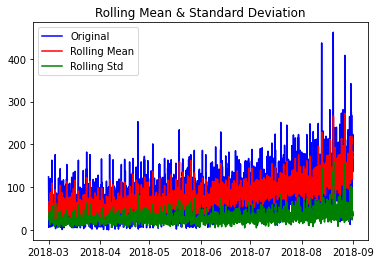

In [9]:
test_station(df)

The data stationary

In [10]:
df.duplicated().sum()

4165

In [11]:
df.isna().sum()

num_orders    0
dtype: int64

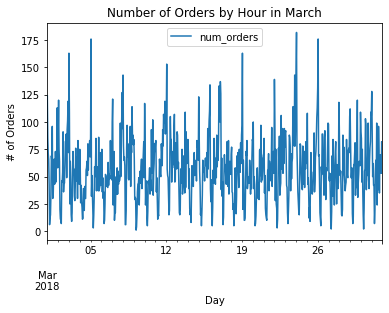

In [12]:
df['2018-03-01':'2018-03-31'].plot()
plt.title('Number of Orders by Hour in March')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

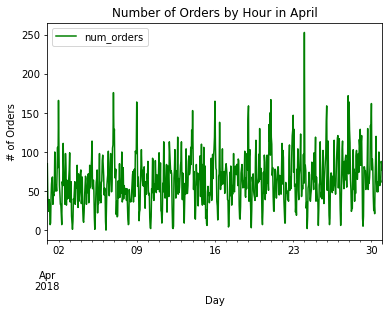

In [13]:
df['2018-04-01':'2018-04-30'].plot(color='green')
plt.title('Number of Orders by Hour in April')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

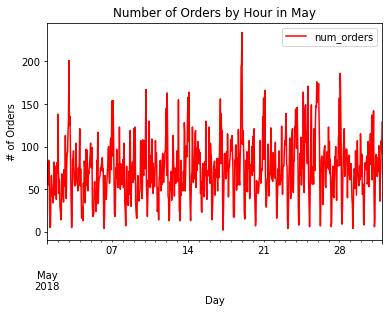

In [14]:
df['2018-05-01':'2018-05-31'].plot(color='red')
plt.title('Number of Orders by Hour in May')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

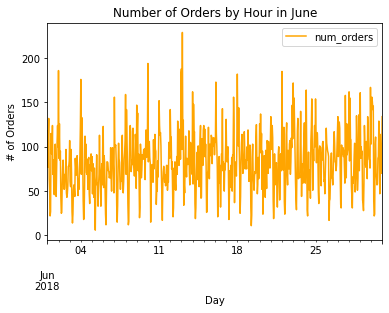

In [15]:
df['2018-06-01':'2018-06-30'].plot(color='orange')
plt.title('Number of Orders by Hour in June')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

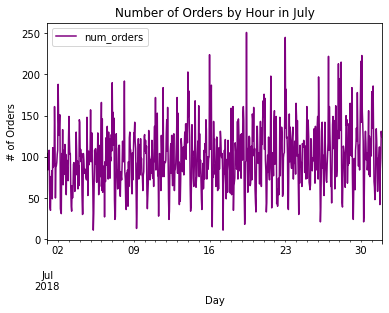

In [16]:
df['2018-07-01':'2018-07-31'].plot(color='purple')
plt.title('Number of Orders by Hour in July')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

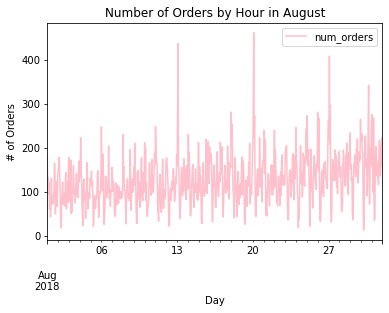

In [17]:
df['2018-08-01':'2018-08-31'].plot(color='pink')
plt.title('Number of Orders by Hour in August')
plt.xlabel('Day')
plt.ylabel('# of Orders')
plt.show()

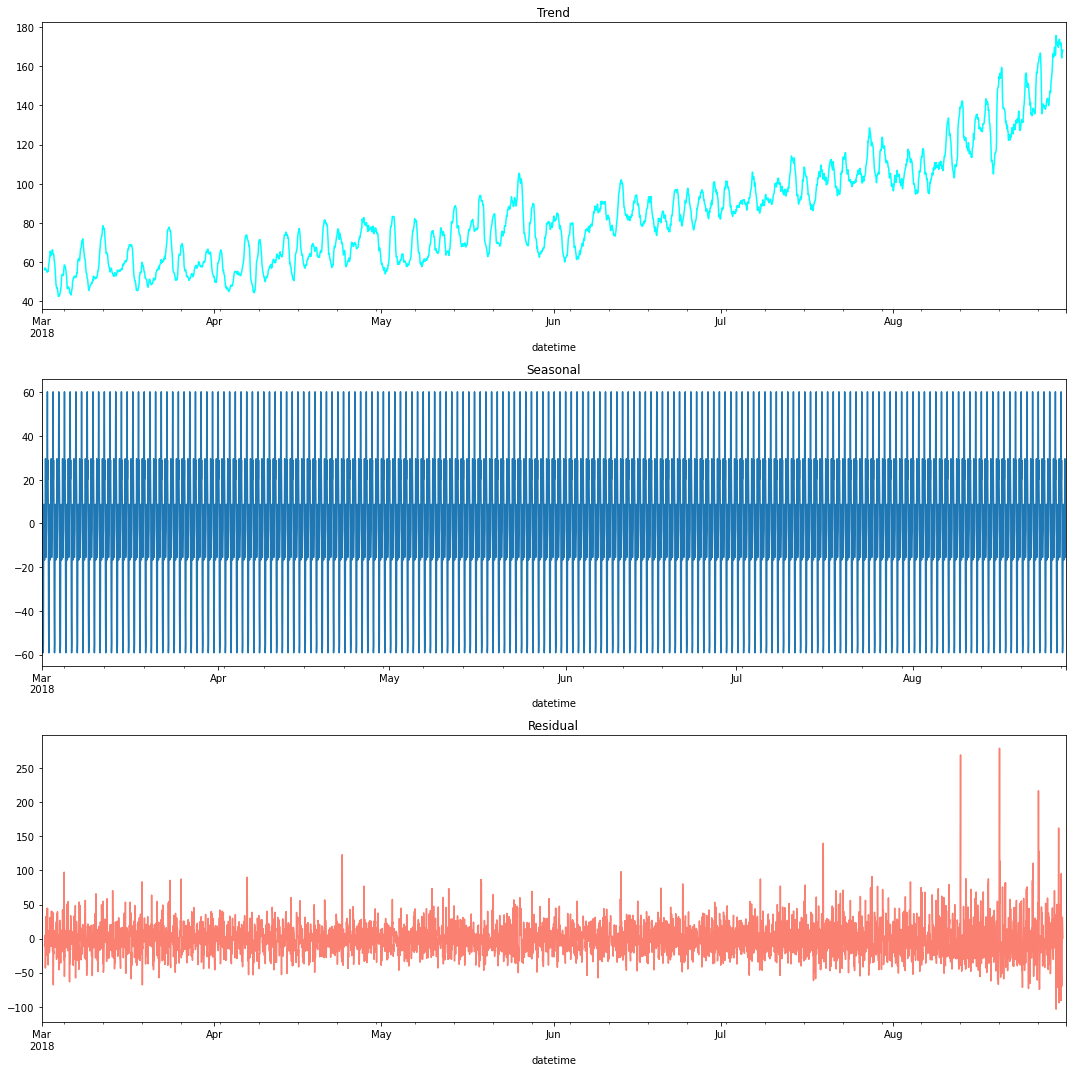

In [23]:
march_data = df['2018-03-01':'2018-08-31']['num_orders']


result = seasonal_decompose(march_data, model='additive', period=24)  # Assuming a daily seasonality with a period of 24 hours


fig, axes = plt.subplots(3, 1, figsize=(15, 15))

result.trend.plot(ax=axes[0],color='aqua')
axes[0].set_title('Trend')

result.seasonal[:-100].plot(ax=axes[1])
axes[1].set_title('Seasonal')

result.resid.plot(ax=axes[2], color='salmon')
axes[2].set_title('Residual')


plt.tight_layout()
plt.show()

We can see seasonality is very consistent regarding taxi orders occuring between March-August. Although, we see an increase of orders as time goes on. 

In [24]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek  # Add day of the week feature
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df # See the difference 4 hours ago 

df = make_features(df, 4, 4)

In [25]:
df

,num_orders,month,day,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,86.50
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,184.25
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,189.25
2018-08-31 21:00:00,159,8,31,21,4,154.0,136.0,207.0,217.0,178.50


## Training

In [26]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)  # Split into train and test sets
train, valid = train_test_split(train, shuffle=False, test_size=0.3)  # Split train set into train and validation sets

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

In [27]:
model = LinearRegression()
model.fit(features_train, target_train)

pred_valid = model.predict(features_valid)

mse = mean_squared_error(target_valid, pred_valid)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 36.53710068723765


In [28]:
model = RandomForestRegressor(n_estimators=150,max_depth=12,random_state=12345)
model.fit(features_train, target_train)

pred_valid= model.predict(features_valid)

mse = mean_squared_error(target_valid, pred_valid)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 32.786020704464605


In [29]:
param_grid = {
    'max_depth': [5, 7, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = DecisionTreeRegressor(random_state=12345)

cv = TimeSeriesSplit()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

grid_search.fit(features_train, target_train)

best_model = grid_search.best_estimator_

pred_valid = best_model.predict(features_valid)

mse = mean_squared_error(target_valid, pred_valid)
rmse = np.sqrt(mse)

print("Best Parameters:", grid_search.best_params_)
print("RMSE:", rmse)


Best Parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
RMSE: 37.47746884421884


## Testing

In [30]:
train_valid = pd.concat([train, valid])  # Concatenate train and validation sets

train_valid = train_valid.dropna()

features_train_valid = train_valid.drop(['num_orders'], axis=1)
target_train_valid = train_valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

model = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=12345)
model.fit(features_train_valid, target_train_valid)

pred_test = model.predict(features_test)

mse = mean_squared_error(target_test, pred_test)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 47.39572815156682


# Conclusion

After importing the data and resampling to show the # of orders per hour, it is found that the data is stationary in all months. Based on trend and seasonality, the orders tend to stay consistent with a gradual increase over time. Although, once August comes around,the data potrays a large increase of orders being called.

After testing and validating the data using LinearRegression, RandomForest, and hyperparamater tuning with DecisionTree, RandomForest had the lowest RMSE score of the 3. Overall, the true number of taxi orders for a specific hour is 100, the model's prediction could be as low as 52.61 or as high as 147.39, on average. The deviation of 47.39 units represents the typical magnitude of the prediction error made by the model.